## Importing libraries

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import shutil

## Collect images

In [15]:
# Define the directory to store the data
DATA_DIR = './data'
# Create the directory if it doesn't exist
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Define the number of alphabet class and the number of images per class
number_of_classes = 24
dataset_size = 200

# Start capturing video from the webcam
cap = cv2.VideoCapture(0)
# Loop over each class
for j in range(number_of_classes):
    # Create a directory for each class if it doesn't exist
    if not os.path.exists(os.path.join(DATA_DIR, str(j))):
        os.makedirs(os.path.join(DATA_DIR, str(j)))

    print('Collecting data for class {}'.format(j))

    # Loop until the user is ready to start collecting images
    while True:
        ret, frame = cap.read()
        cv2.putText(frame, 'Ready? Press "Q" !', (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3,
                    cv2.LINE_AA)
        # Show the webcam feed in a window
        cv2.imshow('frame', frame)
        # Wait for the user to press 'q' to start collecting images
        if cv2.waitKey(25) == ord('q'):
            break

    # Initialize a counter for the number of images collected
    counter = 0
    # Collect images until the dataset size for the class is reached
    while counter < dataset_size:
        ret, frame = cap.read()
        cv2.imshow('frame', frame)
        cv2.waitKey(25)
        # Save the current frame as an image in the respective class folder
        cv2.imwrite(os.path.join(DATA_DIR, str(j), '{}.jpg'.format(counter)), frame)

        # Increment the counter
        counter += 1

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


## Combine data

In [2]:
# Paths to your main folder and other folders
main_folder = './data'
other_folders = ['./Data0', './Data1', './Data2']

# Iterate through labels 0 through 24
for i in range(25):
    label = str(i)
    target_folder = os.path.join(main_folder, label)

    # Ensure the target folder exists in the main folder
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Iterate through each source folder
    for folder in other_folders:
        source_folder = os.path.join(folder, label)

        # Check if the source folder exists
        if os.path.exists(source_folder):
            # Iterate through each file in the source folder
            for filename in os.listdir(source_folder):
                file_path = os.path.join(source_folder, filename)
                if os.path.isfile(file_path):
                    # Create a unique file path in the target folder
                    unique_file_path = os.path.join(target_folder, filename)
                    counter = 1
                    # If a file with the same name exists, add a counter to the filename
                    while os.path.exists(unique_file_path):
                        name, extension = os.path.splitext(filename)
                        unique_file_path = os.path.join(target_folder, f"{name}_{counter}{extension}")
                        counter += 1
                    # Copy file to the unique path in the target folder
                    shutil.copy(file_path, unique_file_path)



## Prepare data

In [6]:
# Initialize MediaPipe Hands for hand landmark detection
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

# Directory containing the dataset
DATA_DIR = './data'

# Lists for storing the processed data and corresponding labels
data = []
labels = []

# Define the expected length of the feature vector (e.g., 21 landmarks * 2 coordinates each)
expected_length = 42

# Iterate through each subdirectory in the dataset
for dir_ in os.listdir(DATA_DIR):
    # Iterate through each image in the subdirectory
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_)):
        # Temporary list to store the current image's data
        data_aux = []

        # Read the image and convert it to RGB color space
        img = cv2.imread(os.path.join(DATA_DIR, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Process the image using MediaPipe Hands to detect hand landmarks
        results = hands.process(img_rgb)

        # Check if any hand landmarks are detected
        if results.multi_hand_landmarks:
            # Loop through each detected hand
            for hand_landmarks in results.multi_hand_landmarks:
                # Extract x and y coordinates of the landmarks
                x_ = [landmark.x for landmark in hand_landmarks.landmark]
                y_ = [landmark.y for landmark in hand_landmarks.landmark]

                # Normalize the coordinates relative to the minimum x and y values
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x - min(x_))
                    data_aux.append(y - min(y_))

            # Ensure the feature vector has the expected length
            if len(data_aux) == expected_length:
                # Append the normalized landmarks and label to the lists
                data.append(data_aux)
                labels.append(dir_)
            else:
                # Skip images with inconsistent feature sizes
                print(f"Skipping image {img_path} in {dir_} due to inconsistent feature size")

# Save the processed data and labels in a pickle file
f = open('data.pickle', 'wb')
pickle.dump({'data': data, 'labels': labels}, f)
f.close()

Skipping image 159_1.jpg in 11 due to inconsistent feature size
Skipping image 160_1.jpg in 11 due to inconsistent feature size
Skipping image 161_1.jpg in 11 due to inconsistent feature size
Skipping image 162_1.jpg in 11 due to inconsistent feature size
Skipping image 165_1.jpg in 11 due to inconsistent feature size
Skipping image 177_1.jpg in 11 due to inconsistent feature size
Skipping image 179_1.jpg in 11 due to inconsistent feature size
Skipping image 180_1.jpg in 11 due to inconsistent feature size
Skipping image 181_1.jpg in 11 due to inconsistent feature size
Skipping image 182_1.jpg in 11 due to inconsistent feature size
Skipping image 188_1.jpg in 11 due to inconsistent feature size
Skipping image 193_1.jpg in 11 due to inconsistent feature size
Skipping image 10_3.jpg in 17 due to inconsistent feature size
Skipping image 11_3.jpg in 17 due to inconsistent feature size
Skipping image 14_3.jpg in 17 due to inconsistent feature size
Skipping image 16_3.jpg in 17 due to incons

## Training Random Forest

In [2]:
# Load the preprocessed data and labels from the pickle file
data_dict = pickle.load(open('./data.pickle', 'rb'))
data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],        # Maximum depth of the trees
    'min_samples_split': [2, 4, 6],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# Initialize GridSearchCV with RandomForestClassifier and the parameter grid
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, verbose=2, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Use the best model found by GridSearchCV
model = grid_search.best_estimator_

# Predict on the test set using the best model
y_predict = model.predict(x_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [3]:
# Calculate the accuracy score and other metrics
score = accuracy_score(y_test, y_predict)
print('{}% of samples were classified correctly !'.format(score * 100))

99.7953814674072% of samples were classified correctly !


In [4]:
# Calculate additional performance metrics
precision_micro = precision_score(y_test, y_predict, average='micro')
precision_macro = precision_score(y_test, y_predict, average='macro')
recall_micro = recall_score(y_test, y_predict, average='micro')
recall_macro = recall_score(y_test, y_predict, average='macro')
f1_micro = f1_score(y_test, y_predict, average='micro')
f1_macro = f1_score(y_test, y_predict, average='macro')

# Print these metrics
print('Micro Precision: {:.2f}%'.format(precision_micro * 100))
print('Macro Precision: {:.2f}%'.format(precision_macro * 100))
print('Micro Recall: {:.2f}%'.format(recall_micro * 100))
print('Macro Recall: {:.2f}%'.format(recall_macro * 100))
print('Micro F1 Score: {:.2f}%'.format(f1_micro * 100))
print('Macro F1 Score: {:.2f}%'.format(f1_macro * 100))

Micro Precision: 99.80%
Macro Precision: 99.80%
Micro Recall: 99.80%
Macro Recall: 99.78%
Micro F1 Score: 99.80%
Macro F1 Score: 99.79%


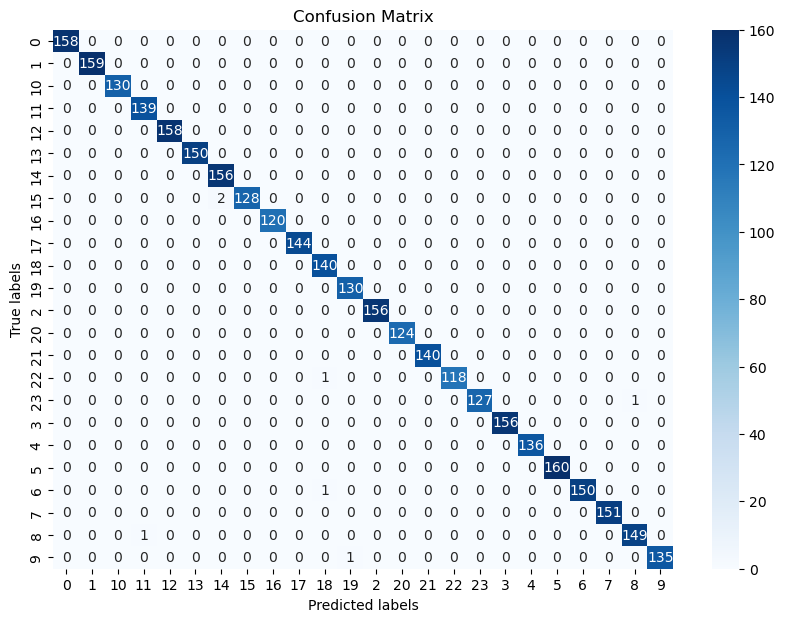

In [5]:
# Create a confusion matrix and visualize it
conf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [6]:
# Save the trained model for future use
f = open('model.p', 'wb')
pickle.dump({'model': model}, f)
f.close()


## Make prediction

In [13]:
# Load the trained model from the pickle file
model_dict = pickle.load(open('./model.p', 'rb'))
model = model_dict['model']

# Start capturing video from the webcam
cap = cv2.VideoCapture(0)

# Initialize MediaPipe components for hand detection and drawing
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Configure MediaPipe Hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

# Define a dictionary to map prediction outputs to labels
labels_dict = {0: 'A', 1: 'B', 2: 'C', 3:'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 
               8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q',
              16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y'}

# Start an infinite loop to process video frames
while True:
    data_aux = []  # List to store processed hand landmark data
    x_ = []        # List to store x coordinates of hand landmarks
    y_ = []        # List to store y coordinates of hand landmarks

    # Read a frame from the webcam
    ret, frame = cap.read()

    # Get the dimensions of the frame
    H, W, _ = frame.shape

    # Convert the frame to RGB color space (required by MediaPipe)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame using MediaPipe Hands
    results = hands.process(frame_rgb)

    # Check if hand landmarks are detected
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw hand landmarks on the frame
            mp_drawing.draw_landmarks(
                frame, hand_landmarks, mp_hands.HAND_CONNECTIONS, 
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

        # Extract and normalize hand landmark data
        for hand_landmarks in results.multi_hand_landmarks:
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                x_.append(x)
                y_.append(y)

            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                data_aux.append(x - min(x_))
                data_aux.append(y - min(y_))

        # Calculate the bounding box for the hand
        x1, y1 = int(min(x_) * W) - 10, int(min(y_) * H) - 10
        x2, y2 = int(max(x_) * W) + 20, int(max(y_) * H) + 20

        # Check if the feature vector has the expected length and make a prediction
        if len(data_aux) <= 42:
            prediction = model.predict([np.asarray(data_aux)])
            predicted_character = labels_dict[int(prediction[0])]

            # Draw the predicted character and a bounding box on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
            cv2.putText(frame, predicted_character, (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('frame', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

In [11]:
cap.release()
cv2.destroyAllWindows()